# C4 copy number analysis
This notebook carries out the C4 genes copy number analysis. Creates main figure 3, supplementary figure 13 and supplementary tables 8 and 9.

In [1]:
import os
import numpy as np
import subprocess
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import session_info

session_info.show(html=False)

-----
matplotlib          3.9.4
numpy               1.26.4
pandas              1.5.3
seaborn             0.13.2
session_info        1.0.0
-----
IPython             8.18.1
jupyter_client      8.6.3
jupyter_core        5.8.1
jupyterlab          4.4.5
notebook            7.4.5
-----
Python 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:27:35) [Clang 11.1.0 ]
macOS-15.6.1-x86_64-i386-64bit
-----
Session information updated at 2025-09-18 16:47


In [2]:
wgs_dir = "../data"
meta_dir = "../data"

A bed file containing 1 kilobase non-overlapping windows for MHC region (chromosome 6 positions 28510000-33482000) was created. MHC locus read coverage for each sample was extracted from WGS reads mapped to human genome assembly hg38 using samtools v1.16.1 bedcov command and the MHC bed file. These were saved in "coverage" directory.

Coverage based on uniquely mapping reads were extracted using the same bedcov command with additional "-Q 30". These were saved in "cov_30" directory.

### Load and annotate coverage per sample
Get per coverage values for all samples and create a dataframe

In [3]:
cov_list = []

for f in os.scandir(os.path.join(wgs_dir, "coverage")):
    sam = int(f.name.split("_")[0])
    cov = pd.read_table(f.path, header=None)
    cov["mp257_maskid"] = sam
    cov_list.append(cov)
    
cov_df = pd.concat(cov_list, axis=0, ignore_index=True)

In [4]:
cov_df.head()

,0,1,2,3,mp257_maskid
0,chr6,28510000,28511000,44592,390501
1,chr6,28511000,28512000,42150,390501
2,chr6,28512000,28513000,37621,390501
3,chr6,28513000,28514000,41003,390501
4,chr6,28514000,28515000,34818,390501


In [5]:
cov_df.columns = ["chrom", "start", "end", "cov", "mp257_maskid"]

The values under "cov" are total base coverage per 1 kb window. We'll create a "coverage" column which has the normalized coverage for each sample. This is a sample-wise normalization where we get the sum of all 4972 1Kb windows for each sample and use that as normalizer for each row. Values are multiplied by 2 with the assumption that the average value should be 2 for a "normal" diploid region.

In [6]:
cov_df["total"] = cov_df.groupby("mp257_maskid")["cov"].transform("sum")

In [7]:
cov_df["coverage"] = cov_df["cov"] / cov_df["total"] * 4972 * 2
cov_df.head()

,chrom,start,end,cov,mp257_maskid,total,coverage
0,chr6,28510000,28511000,44592,390501,188841638,2.348120
1,chr6,28511000,28512000,42150,390501,188841638,2.219530
2,chr6,28512000,28513000,37621,390501,188841638,1.981042
3,chr6,28513000,28514000,41003,390501,188841638,2.159131
4,chr6,28514000,28515000,34818,390501,188841638,1.833442


Annotate each bin with a region name. The names are based on the gene overlapping the region except for HERV insertion within the C4 genes, where the region is annotated as HERV. Flanking regions to the left and right of the region of interest is marked as such. C4 label is used for both C4A and C4B because most reads are non-uniquely mapping to both genes.

In [8]:
cov_df["region"] = pd.cut(cov_df["start"], bins=[28500000, 31957000, 31982000, 
                              31985000, 31991000, 32004000,
                              32009000, 32014000, 32017000,
                              32024000, 32037000, 32042000,
                              32046000, 32071000, 33483000], 
       labels=["left", "left_flank", "C4", "HERV", "C4",
               "CYP21A1P", "TNXA", "C4", "HERV", 
               "C4", "CYP21A2", "intergenic",
               "right_flank", "right"], right=False,
       ordered=False
  )
cov_df.head()

,chrom,start,end,cov,mp257_maskid,total,coverage,region
0,chr6,28510000,28511000,44592,390501,188841638,2.348120,left
1,chr6,28511000,28512000,42150,390501,188841638,2.219530,left
2,chr6,28512000,28513000,37621,390501,188841638,1.981042,left
3,chr6,28513000,28514000,41003,390501,188841638,2.159131,left
4,chr6,28514000,28515000,34818,390501,188841638,1.833442,left


Get the average coverage for each region per sample. 

In [9]:
region_cov = cov_df.groupby(
    ["mp257_maskid", "region"])["coverage"].mean().reset_index()
region_cov.head()

,mp257_maskid,region,coverage
0,202958,C4,1.079661
1,202958,CYP21A1P,0.197682
2,202958,CYP21A2,2.210573
3,202958,HERV,0.609463
4,202958,TNXA,0.586654


### Plot average coverage distribution for C4 and flanking regions
This will create supplementary figure 13 panel B.  
We use these histograms to estimate the average coverage for each copy of C4 gene.

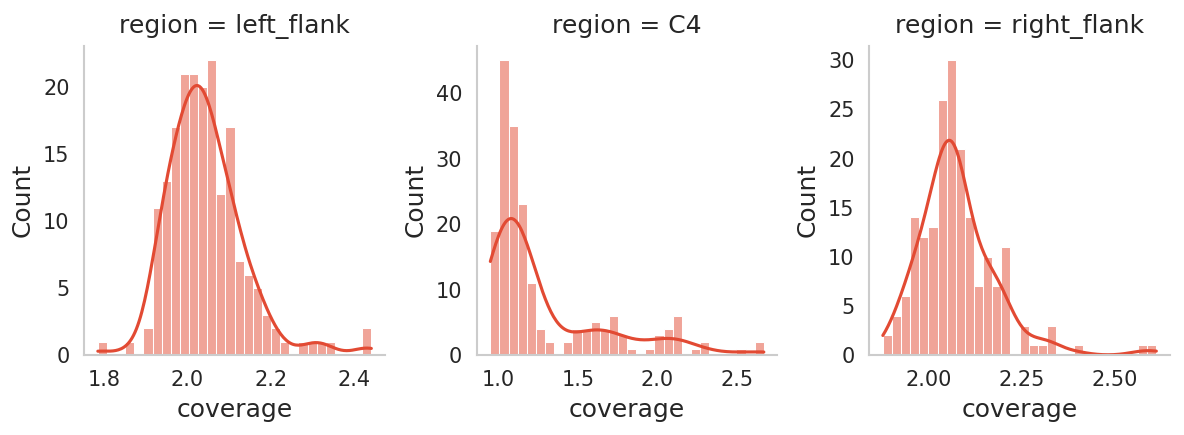

In [10]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    select_cols = ["left_flank", "C4", "right_flank"]
    g = sns.FacetGrid(data=region_cov.loc[region_cov["region"].isin(select_cols)], col="region",
                      col_wrap=3, sharey=False, sharex=False, col_order=select_cols)
    g.map_dataframe(sns.histplot, x="coverage", kde=True, bins=30)
    g.fig.set_size_inches(8,3)
    g.fig.set_dpi(150)
    g.fig.tight_layout(h_pad=2)

### Load and annotate coverage based on uniquely mapping reads
Since these are uniquely mapping reads, we label C4A and C4B individually.

In [11]:
cov_list = []

for f in os.scandir(os.path.join(wgs_dir, "cov_30")):
    sam = int(f.name.split("_")[0])
    cov = pd.read_table(f.path, header=None)
    cov["mp257_maskid"] = sam
    cov_list.append(cov)
    
uniq_cov_df = pd.concat(cov_list, axis=0, ignore_index=True)
uniq_cov_df.columns = ["chrom", "start", "end", "cov", "mp257_maskid"]
uniq_cov_df["total"] = uniq_cov_df.groupby("mp257_maskid")["cov"].transform("sum")
uniq_cov_df["coverage"] = uniq_cov_df["cov"] / uniq_cov_df["total"] * 4972 * 2
uniq_cov_df["region"] = pd.cut(uniq_cov_df["start"], bins=[28500000, 31957000, 31981000, 
                              31994000, 31997000, 32004000,
                              32014000, 32027000, 32030000,
                              32037000, 32042000,
                              32046000, 32071000, 33483000], 
       labels=["left", "left_flank", "non-uniq", "C4A", "non-uniq",
               "CYP21A1P", "non-uniq", "C4B", "non-uniq", 
               "CYP21A2", "intergenic",
               "right_flank", "right"],
       ordered=False, right=False
  )
uniq_cov_df.head()


,chrom,start,end,cov,mp257_maskid,total,coverage,region
0,chr6,28510000,28511000,44592,390501,186515407,2.377406,left
1,chr6,28511000,28512000,42150,390501,186515407,2.247212,left
2,chr6,28512000,28513000,37621,390501,186515407,2.005750,left
3,chr6,28513000,28514000,41003,390501,186515407,2.186060,left
4,chr6,28514000,28515000,34818,390501,186515407,1.856309,left


Get region coverage for C4A and C4B.

In [12]:
uniq_c4_cov_df = uniq_cov_df.loc[
    uniq_cov_df["region"].isin(["C4A", "C4B"])].copy()
uniq_c4_region_cov = uniq_c4_cov_df.groupby(
    ["mp257_maskid", "region"])["coverage"].mean().dropna().reset_index()
uniq_c4_region_cov.head()

,mp257_maskid,region,coverage
0,202958,C4A,0.274041
1,202958,C4B,0.353208
2,207503,C4A,0.632756
3,207503,C4B,0.384516
4,207947,C4A,0.278996


### Plot average coverage distribution for C4A and C4B
This will create supplementary figure 13 panel C.  
We use these histograms to estimate the average coverage for each copy of C4 genes.

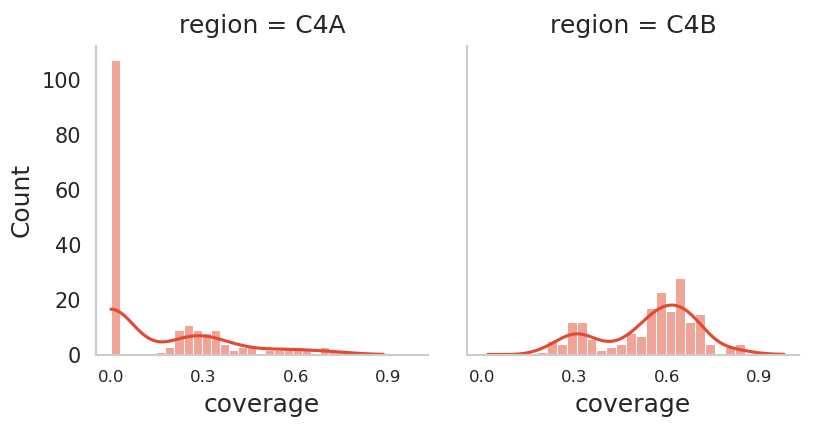

In [13]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    select_cols = ["C4A", "C4B"]
    g = sns.FacetGrid(data=uniq_c4_region_cov, col="region",
                      col_wrap=3, sharey=True, sharex=True, col_order=select_cols)
    g.map_dataframe(sns.histplot, x="coverage", kde=True, bins=30)

    g.fig.set_size_inches(8,3)


    g.fig.set_dpi(150)
    g.fig.tight_layout(h_pad=2)
    g.set(xticks=[0, .3, .6, .9])
    _ = [plt.setp(ax.get_xticklabels(), rotation=0, fontsize=8) for ax in g.axes.flat]
    

In [16]:
uniq_c4_region_tab = uniq_c4_region_cov.pivot(index="mp257_maskid", columns="region", values="coverage")
uniq_c4_region_tab.head()

region,C4A,C4B
mp257_maskid,,
202958,0.274041,0.353208
207503,0.632756,0.384516
207947,0.278996,0.580953
208262,0.700570,0.500331
211000,0.435205,0.310945


Combine average region coverage values from unique and non-unique counts

In [17]:
uniq_c4_region_cov.shape

(376, 3)

In [18]:
region_cov.shape

(1880, 3)

In [19]:
combined_region_cov = pd.concat([uniq_c4_region_cov,
                                region_cov], ignore_index=True)
combined_region_cov.shape

(2256, 3)

In [20]:
combined_region_cov.head()

,mp257_maskid,region,coverage
0,202958,C4A,0.274041
1,202958,C4B,0.353208
2,207503,C4A,0.632756
3,207503,C4B,0.384516
4,207947,C4A,0.278996


Pivot table to have regions as columns and samples as rows. Values will be the average coverages. We'll use these to estimate gene copy numbers

In [21]:
combined_region_tab = combined_region_cov.pivot(
    index="mp257_maskid", columns="region", values="coverage")
combined_region_tab.head()

region,C4,C4A,C4B,CYP21A1P,CYP21A2,HERV,TNXA,intergenic,left,left_flank,right,right_flank
mp257_maskid,,,,,,,,,,,,
202958,1.079661,0.274041,0.353208,0.197682,2.210573,0.609463,0.586654,1.611810,2.042982,1.993507,1.939153,2.078528
207503,2.136396,0.632756,0.384516,1.061128,3.119022,1.253281,2.078187,2.467836,2.022974,2.043051,1.943263,2.078701
207947,1.552054,0.278996,0.580953,0.989485,2.162822,0.608392,1.182317,2.045885,2.033086,1.948089,1.949370,1.970269
208262,2.103808,0.700570,0.500331,2.162522,2.181899,2.226937,2.072999,1.968467,2.027932,2.121200,1.923242,2.030448
211000,1.603459,0.435205,0.310945,0.891975,2.195772,1.208619,1.034689,2.132224,2.033543,1.985881,1.941424,1.968771


### Assign gene copy numbers
The heuristic used in GCN assignment is indicated in the paper as follows.

> Total C4 Gene Copy Number (GCN) estimation

> We estimated the total C4 GCN based on the read coverage of the C4 region including C4A and C4B but excluding the intronic HERV insertion (Supplementary Figure 13A). Histograms of per sample coverage for C4 region as well as 25 kilobases flanking regions on both sides were plotted (Supplementary Figure 13 B). While the flanking regions showed a single peak around 2, indicating a normal diploid status; C4 region showed 3 peaks around 1, 1.5 and 2, likely representing 2, 3 and 4 GCNs, respectively. Since the three peaks in the C4 histogram was well separated, we estimated total C4 GCN based on these peaks: samples under the first peak (coverage < 1.4) were assigned 2 GCN; those under the second peak (1.4<coverage<1.9) were assigned 3 GCN and those under the third peak (coverage > 1.9) were assigned 4 GCN. 

> C4A and C4B Gene Copy Number (GCN) estimation

> Histograms of coverage based on reads uniquely mapping to either C4A or C4B were created (Supplementary Figure 13 C). We observed a major peak at 0 coverage for C4A, indicating total C4A deletions and a separate peak around 0.3 indicating 1 GCN; and 2 peaks for C4B around 0.3 and 0.6, which likely indicate GCNs of 1 and 2. Since total gene deletions were well separated in the histograms for C4A and C4B, we first assigned the GCNs of C4A or C4B null samples (average coverage below 0.04). However, because the peaks for 1 and 2 GCNs were not clearly separated, the rest of the C4A and C4B GCNs were estimated based on the total C4 GCN and the ratio of unique coverage of C4A and C4B. The exact heuristic used was: if a sample was C4A null, C4B was assigned the same value as total C4 GCN; if C4B null, C4A was assigned the C4 GCN. For samples where neither C4A nor C4B was null: if C4 GCN was 2, C4A and C4B each were assigned 1 GCN; if C4 GCN was 3, C4A and C4B coverage were compared and larger received 2 GCN and smaller 1 GCN; if C4 GCN was 4, C4A and C4B were each assigned 2 GCN unless the coverage ratio between them was larger than 2.5 in which case the gene with more coverage was assigned 3 and the other 1 GCN.


In [22]:
# Assign total C4 GCN
combined_region_tab["C4_copy"] = combined_region_tab["C4"].apply(
    lambda a: 2 if a < 1.4 else 3 if a < 1.9 else 4)

# get C4B/C4A ratio
combined_region_tab["C4B_A_ratio"] = combined_region_tab["C4B"] / combined_region_tab["C4A"]

# Assign total deletions for C4A as well as C4B
c4a_null_mask = combined_region_tab["C4A"] < 0.04
c4b_null_mask = combined_region_tab["C4B"] < 0.04

# c4a null gets c4 copy as c4b copy - since c4b is the only source of c4
combined_region_tab.loc[c4a_null_mask, "C4B_copy"] = combined_region_tab.loc[
    c4a_null_mask, "C4_copy"]
combined_region_tab.loc[c4a_null_mask, "C4A_copy"] = 0

# c4b null gets c4 copy as c4a copy - since c4a is the only source of c4
combined_region_tab.loc[c4b_null_mask, "C4A_copy"] = combined_region_tab.loc[
    c4b_null_mask, "C4_copy"]
combined_region_tab.loc[c4b_null_mask, "C4B_copy"] = 0

# 2 C4 copies and not c4a or c4b null gets 1 copy each 
combined_region_tab.loc[(combined_region_tab["C4_copy"] == 2)
                     &~ c4a_null_mask &~ c4b_null_mask, "C4A_copy"] = 1
combined_region_tab.loc[(combined_region_tab["C4_copy"] == 2)
                     &~ c4a_null_mask &~ c4b_null_mask, "C4B_copy"] = 1

# 3 C4 copies and no null: larger of C4A/C4B gets 2 copies
large_a_mask = combined_region_tab["C4A"] > combined_region_tab["C4B"]
combined_region_tab.loc[(combined_region_tab["C4_copy"] == 3)
                     &~ c4a_null_mask &~ c4b_null_mask & large_a_mask, "C4A_copy"] = 2
combined_region_tab.loc[(combined_region_tab["C4_copy"] == 3)
                     &~ c4a_null_mask &~ c4b_null_mask & large_a_mask, "C4B_copy"] = 1
combined_region_tab.loc[(combined_region_tab["C4_copy"] == 3)
                     &~ c4a_null_mask &~ c4b_null_mask &~ large_a_mask, "C4A_copy"] = 1
combined_region_tab.loc[(combined_region_tab["C4_copy"] == 3)
                     &~ c4a_null_mask &~ c4b_null_mask &~ large_a_mask, "C4B_copy"] = 2

# 4 C4 copies and no null: if B/A ratio > 2.5 3B 1A; if B/A ratio < 0.4: 3A 1B; otherwise 2/2
large_a_mask = combined_region_tab["C4B_A_ratio"] < 0.4
large_b_mask = combined_region_tab["C4B_A_ratio"] > 2.5
equal_ab_mask = ~(large_a_mask | large_b_mask)
combined_region_tab.loc[(combined_region_tab["C4_copy"] == 4)
                     &~ c4a_null_mask &~ c4b_null_mask & large_a_mask, "C4A_copy"] = 3
combined_region_tab.loc[(combined_region_tab["C4_copy"] == 4)
                     &~ c4a_null_mask &~ c4b_null_mask & large_a_mask, "C4B_copy"] = 1

combined_region_tab.loc[(combined_region_tab["C4_copy"] == 4)
                     &~ c4a_null_mask &~ c4b_null_mask & large_b_mask, "C4A_copy"] = 1
combined_region_tab.loc[(combined_region_tab["C4_copy"] == 4)
                     &~ c4a_null_mask &~ c4b_null_mask & large_b_mask, "C4B_copy"] = 3

combined_region_tab.loc[(combined_region_tab["C4_copy"] == 4)
                     &~ c4a_null_mask &~ c4b_null_mask & equal_ab_mask, "C4A_copy"] = 2
combined_region_tab.loc[(combined_region_tab["C4_copy"] == 4)
                     &~ c4a_null_mask &~ c4b_null_mask & equal_ab_mask, "C4B_copy"] = 2

# assign HERV insertion copy numbers
combined_region_tab["HERV_copy"] = combined_region_tab["HERV"].apply(
    lambda a: 0 if a < 0.2 else 1 if a < 0.8 else 2 if a < 1.4 else 3 if a < 2 else 4)



In [23]:
combined_region_tab.head()

region,C4,C4A,C4B,CYP21A1P,CYP21A2,HERV,TNXA,intergenic,left,left_flank,right,right_flank,C4_copy,C4B_A_ratio,C4B_copy,C4A_copy,HERV_copy
mp257_maskid,,,,,,,,,,,,,,,,,
202958,1.079661,0.274041,0.353208,0.197682,2.210573,0.609463,0.586654,1.611810,2.042982,1.993507,1.939153,2.078528,2,1.288890,1.0,1.0,1
207503,2.136396,0.632756,0.384516,1.061128,3.119022,1.253281,2.078187,2.467836,2.022974,2.043051,1.943263,2.078701,4,0.607685,2.0,2.0,2
207947,1.552054,0.278996,0.580953,0.989485,2.162822,0.608392,1.182317,2.045885,2.033086,1.948089,1.949370,1.970269,3,2.082299,2.0,1.0,1
208262,2.103808,0.700570,0.500331,2.162522,2.181899,2.226937,2.072999,1.968467,2.027932,2.121200,1.923242,2.030448,4,0.714177,2.0,2.0,4
211000,1.603459,0.435205,0.310945,0.891975,2.195772,1.208619,1.034689,2.132224,2.033543,1.985881,1.941424,1.968771,3,0.714479,1.0,2.0,2


### Coverage heatmap plots

Get pivot table of non-unique coverage for supplementary figure 13 panel A.

In [24]:
cov_tab = cov_df.pivot_table(index="mp257_maskid",
                         columns="start",
                         values="coverage")
cov_tab.head()

start,28510000,28511000,28512000,28513000,28514000,28515000,28516000,28517000,28518000,28519000,...,33472000,33473000,33474000,33475000,33476000,33477000,33478000,33479000,33480000,33481000
mp257_maskid,,,,,,,,,,,,,,,,,,,,,
202958,1.823091,2.642633,2.434350,2.078330,2.237674,2.180803,2.381591,1.936445,2.011546,2.027892,...,1.929094,1.953806,1.957094,1.982241,2.166779,2.144437,2.093515,2.017301,2.336375,1.671630
207503,1.806126,2.418206,2.035493,1.766098,2.378965,2.093673,1.902657,2.139421,1.865462,2.017393,...,1.553520,1.911051,1.842116,2.027781,2.056950,2.477279,2.230076,1.958163,1.956694,1.987437
207947,2.091493,2.188100,1.986571,2.055360,2.140326,2.060248,2.218639,2.268833,1.898732,1.987175,...,2.009853,2.073250,1.920452,1.768562,1.906946,2.045785,2.126870,2.495510,1.812607,2.000429
208262,2.057617,2.179927,2.150412,1.938977,2.042204,2.097566,2.151198,1.997065,1.913970,1.888124,...,1.651211,2.148786,2.232353,1.898819,1.918269,2.224018,1.871977,1.882619,2.049806,1.561248
211000,2.117673,2.344864,2.747748,2.026755,2.096786,1.741204,2.276369,2.264441,1.957594,2.087009,...,1.991279,2.212225,2.084910,2.030134,2.158729,1.937373,1.990153,2.221951,2.341434,2.154122


Plot heatmap

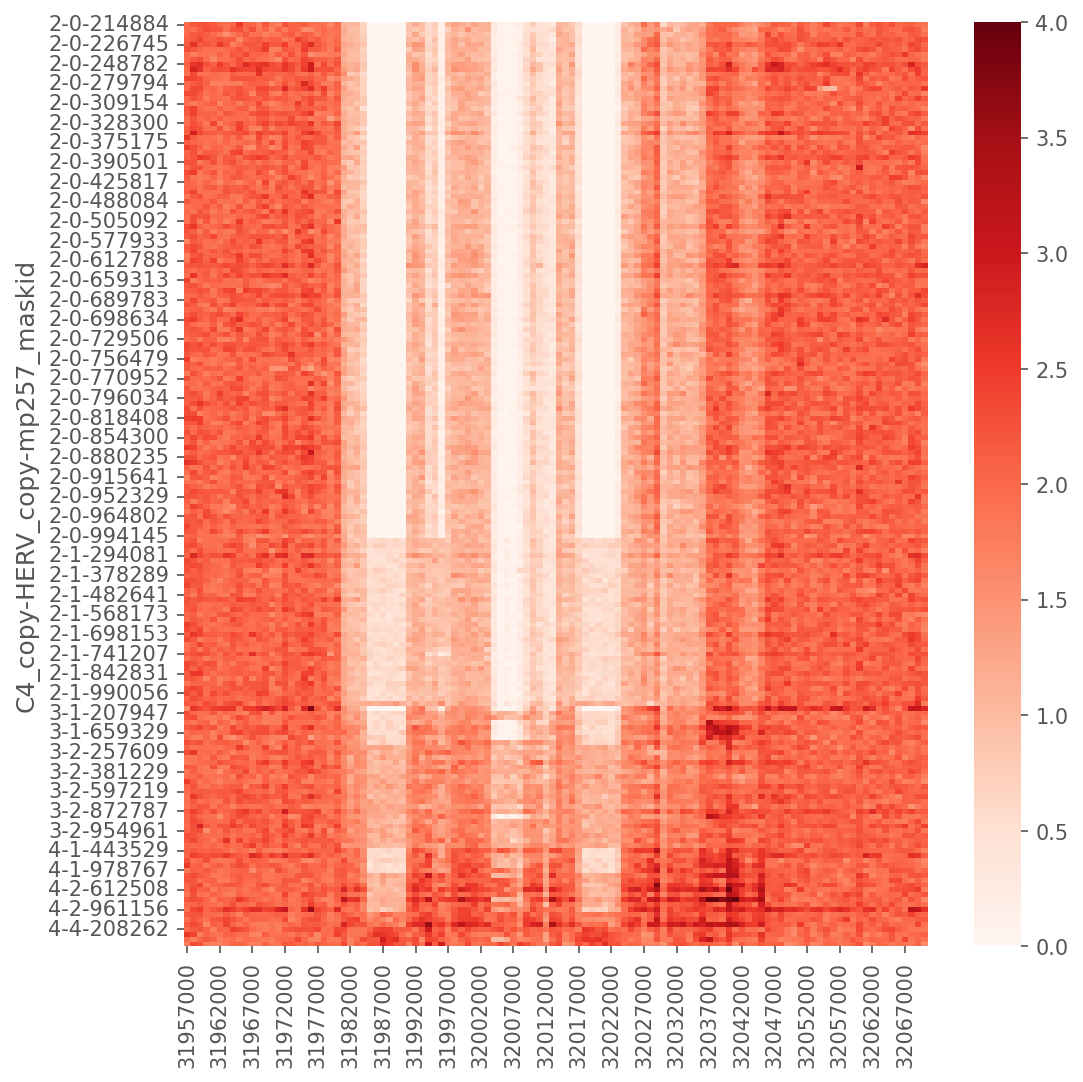

In [25]:
data = cov_tab.reset_index().merge(
    combined_region_tab.reset_index()[["mp257_maskid", "C4_copy", "HERV_copy"]]).set_index(
        ["C4_copy", "HERV_copy", "mp257_maskid"])
fig, ax = plt.subplots()
data = data.sort_index().loc[:, pd.IndexSlice[31957000:32070000]]
sns.heatmap(data, rasterized=True, vmax=4, 
            cmap=sns.color_palette("Reds", as_cmap=True)
,
            ax=ax, yticklabels=4)
fig.set_size_inches(8,8)
fig.set_dpi(150)
# uncomment the following line to save a pdf copy
#fig.savefig("c4_shared_copy.pdf", facecolor="w", bbox_inches="tight")

Pivot unique coverage table for main figure 3

In [26]:
uniq_cov_all_tab = uniq_cov_df.pivot_table(index=["mp257_maskid"],
                         columns="start",
                         values="coverage")
uniq_cov_all_tab.head()

start,28510000,28511000,28512000,28513000,28514000,28515000,28516000,28517000,28518000,28519000,...,33472000,33473000,33474000,33475000,33476000,33477000,33478000,33479000,33480000,33481000
mp257_maskid,,,,,,,,,,,,,,,,,,,,,
202958,1.847250,2.677653,2.442012,2.105872,2.267327,2.209703,2.413151,1.962106,2.032519,2.054765,...,1.920015,1.974258,1.978521,2.008509,2.192504,2.168004,2.121258,2.041094,2.364543,1.689813
207503,1.839598,2.463021,2.069260,1.798827,2.423052,2.132473,1.937918,2.179069,1.900032,2.053230,...,1.561951,1.941444,1.864659,2.063489,2.090367,2.517417,2.266114,1.993383,1.990925,2.009894
207947,2.123917,2.222021,2.017368,2.087223,2.173506,2.092187,2.253034,2.304006,1.924534,2.016958,...,2.019517,2.105391,1.943060,1.795979,1.936509,2.077500,2.159842,2.534196,1.840707,2.031441
208262,2.096848,2.221490,2.191411,1.975946,2.081141,2.137558,2.192212,2.035141,1.950462,1.920971,...,1.650744,2.184092,2.260597,1.927702,1.952599,2.266421,1.905958,1.918513,2.088887,1.575040
211000,2.151939,2.382807,2.792209,2.059550,2.130715,1.769379,2.313203,2.297805,1.987970,2.120779,...,1.988074,2.246565,2.113132,2.056481,2.184556,1.968722,2.018818,2.254940,2.379321,2.179146


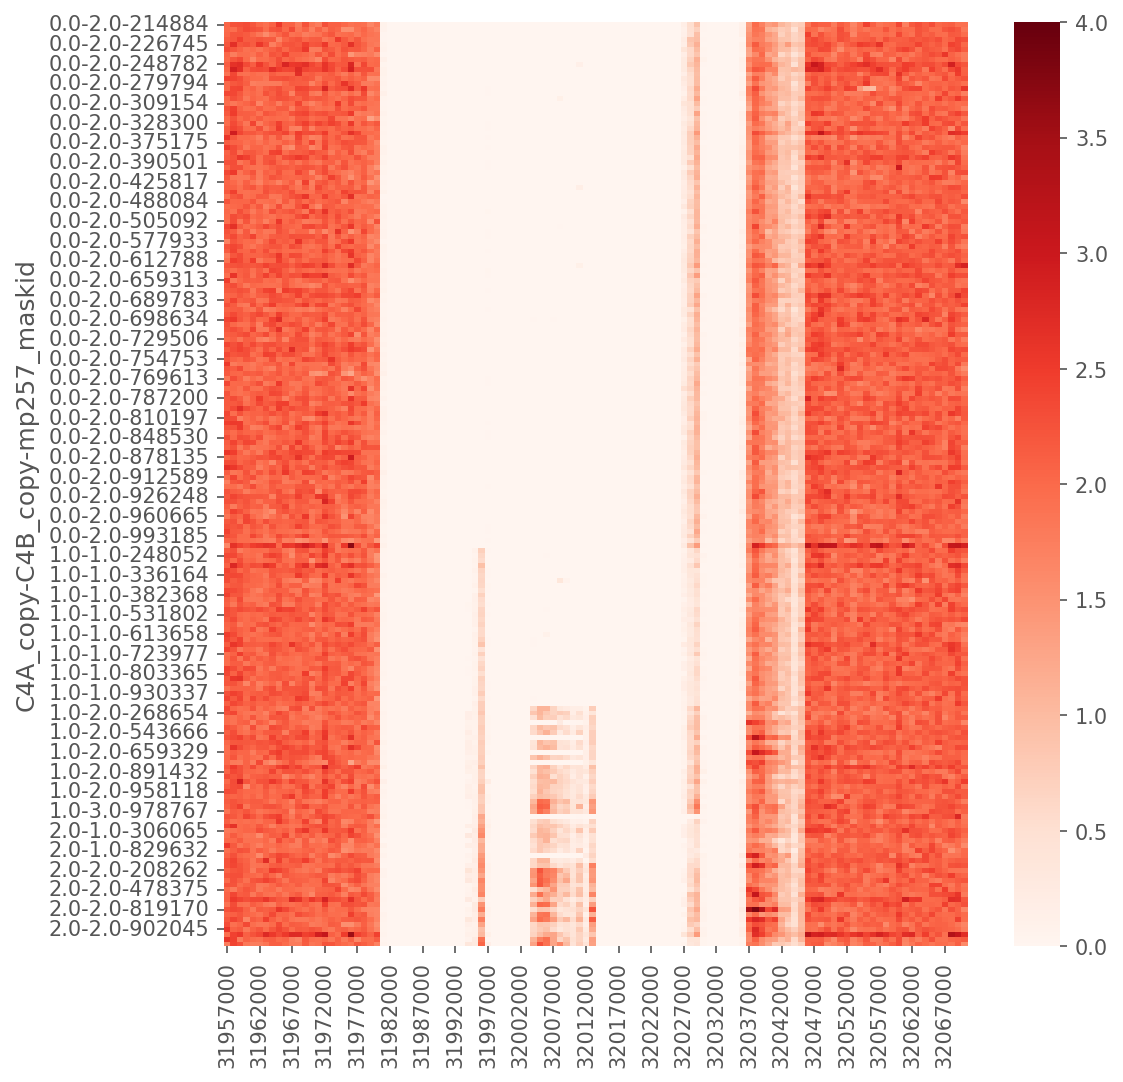

In [27]:
data = uniq_cov_all_tab.reset_index().merge(
    combined_region_tab.reset_index()[["mp257_maskid", "C4A_copy", "C4B_copy"]]).set_index(
        ["C4A_copy", "C4B_copy", "mp257_maskid"])
fig, ax = plt.subplots()
sns.heatmap(data.sort_index().loc[:, pd.IndexSlice[31957000:32070000]],
            ax=ax, yticklabels=4, rasterized=True, vmax=4, cmap="Reds")
fig.set_size_inches(8,8)
fig.set_dpi(150)
# uncomment the following line to save figure as pdf
#fig.savefig("c4_uniq_copy.pdf", facecolor="w", bbox_inches="tight")

### C4 copy numbers vs tri-snp 101
Load the metadata file to add tri-snp calls to copy number calls. This will be used for generating supplementary tables 8 and 9.

In [28]:
meta = pd.read_csv(os.path.join(meta_dir, "filtered_meta_final.csv"))

In [29]:
meta_cn = meta[["mp257_maskid", "tri-SNP 101"]].merge(
    combined_region_tab[["C4A_copy", "C4B_copy"]].reset_index())
meta_cn

,mp257_maskid,tri-SNP 101,C4A_copy,C4B_copy
0,388371,2,0.0,2.0
1,952604,2,1.0,2.0
2,853407,1,1.0,1.0
3,551831,1,1.0,1.0
4,842831,1,1.0,1.0
...,...,...,...,...
183,293434,2,0.0,2.0
184,854300,2,0.0,2.0
185,612508,1,2.0,2.0
186,744291,2,0.0,2.0


#### Supplementary table 8

In [30]:
meta_cn.pivot_table(index="C4A_copy",
                    columns="tri-SNP 101",
                    values="mp257_maskid",
                    aggfunc="count").fillna(0).astype(int)

tri-SNP 101,0,1,2
C4A_copy,,,
0.0,0,0,107
1.0,0,44,10
2.0,9,9,7
3.0,1,0,1


#### Supplementary table 9

In [31]:
meta_cn.pivot_table(index="C4B_copy",
                    columns="tri-SNP 101",
                    values="mp257_maskid",
                    aggfunc="count").fillna(0).astype(int)

tri-SNP 101,0,1,2
C4B_copy,,,
0.0,1,0,0
1.0,5,34,4
2.0,4,17,119
3.0,0,2,2
